In [71]:
# Load the fine tuned segformer model
from transformers import SegformerForSemanticSegmentation
model = 'gray' # gray, deoldify_part, deoldify_all
model_dir = f'./segformer_model/{model}'

id2label = {0: 'Non-Forest', 
            1: 'Forest',
            255: 'NoData'}
label2id = {'Non-Forest' : 0, 
            'Forest': 1,
            'NoData':255}

tranined_model = SegformerForSemanticSegmentation.from_pretrained(model_dir, num_labels=3)
tranined_model.eval()  # Set the model to evaluation mode

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, mode='test'):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the test images + annotations.
        """
        self.root_dir = root_dir
        self.transforms = self.create_transforms()

        #sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "input")
        self.ann_dir = os.path.join(self.root_dir, "target")
        self.images = sorted([f for _, _, files in os.walk(self.img_dir) for f in files])
        self.annotations = sorted([f for _, _, files in os.walk(self.ann_dir) for f in files])
        
    def create_transforms(self):
        _transforms = A.Compose([
            # A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0, mask_value=255),
            A.Resize(height=256, width=256), 
            ToTensorV2(),
#             A.Normalize([0.485, 0.456, 0.406, 0], [0.229, 0.224, 0.225, 1])
        ], p = 1,
        )
        return _transforms
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.array(Image.open(os.path.join(self.img_dir, self.images[idx])))
        transformed = self.transforms(image=image)
        transformed_image = transformed["image"]

        mask  = np.array(Image.open(os.path.join(self.ann_dir, self.annotations[idx])).convert('L'))
        mask[mask > 1] = 255 #change all non-valid label value to 255

        return {"image": transformed_image, "mask": mask}
    
def show_sample(image, mask, predicts):
    colors = [(0, 0, 0), (0,0.5,0), (0.5, 0.5, 0.5)]
    n_bins = [3]  # Discretizes the interpolation into bins
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=3)
    # Adjust mask for 'NoData' to be white or transparent
    mask_display = np.copy(mask)
    mask_display[mask == 255] = 2  # 2 corresponds to grey in the custom colormap
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.subplot(1, 3, 2)
    plt.imshow(mask_display, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
    plt.title("Mask (Forest in Dark Green)")
    plt.subplot(1, 3, 3)
    plt.imshow(predicts, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
    # plt.title("Predict  (Forest in Dark Green)")
    plt.show()

Forest IoU: 0.8885503024871163
Non-Forest IoU: 0.7518583187827388


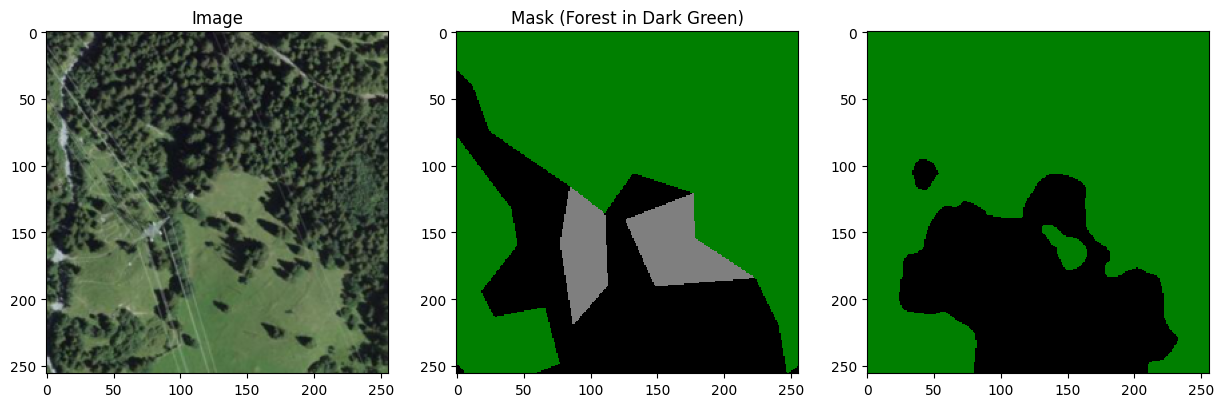

In [73]:
from torch.utils.data import DataLoader

data_dir = 'inference_images'

if os.path.exists(data_dir):
    test_dataset = SemanticSegmentationDataset(root_dir=data_dir,mode="test")
    test_dataloader = DataLoader(test_dataset, batch_size=1)
    
    for idx, batch in enumerate(test_dataloader):
        pixel_values = batch["image"].float()
        labels = batch["mask"].long()
        outputs = tranined_model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        # evaluate
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
            # note that the metric expects predictions + labels as numpy arrays
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        metrics = metric._compute(references = labels.cpu(), 
                                  predictions = predicted.cpu(),
                                  num_labels=len(id2label), 
                                  ignore_index=255,
                                  reduce_labels=False, # we've already reduced the labels before)
        )
        forest_IoU = metrics["per_category_iou"][1]
        non_forest_IoU = metrics["per_category_iou"][0]
        print("Forest IoU:", forest_IoU)
        print("Non-Forest IoU:", non_forest_IoU)
        
        pixel_values =  batch["image"].squeeze(0).permute(1, 2, 0)
        labels =  batch["mask"].squeeze(0)
        predicted = predicted.squeeze(0)
        pixel_values = pixel_values.to('cpu').numpy()
        labels = labels.to('cpu').numpy()
        predicted = predicted.to('cpu').numpy()
        show_sample(pixel_values, labels, predicted)
